In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
from misc.jupyter import end_interactive
from scipy.stats import ttest_1samp
import matplotlib.ticker as mticker
import pandas as pd

from datetime import datetime, timedelta
from urllib.request import urlopen

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from metpy.units import masked_array, units

from netCDF4 import Dataset

#from geoplots import mapplot, xticksyear, xticksmonth, yticks2lat
#import geoxarray

In [2]:
land = xr.open_dataset('/tigress/tessj/data/land_mask.FLOR.atmos_month.nc')
land_mask = land.land_mask.rename({'grid_yt':'lat','grid_xt':'lon'}).squeeze(drop=True)

In [3]:
def shift_longitude(da):
    return da.roll(lon=da.lon.size//2).pipe(lambda x: x.assign_coords(lon=x.lon.where(x.lon<180, other=x.lon-360)))


# Load precip data

In [4]:
#get data as dataarray
# scale precip from km/year to mm/day
sf_precip = 3600*24

pinatubo_p = sf_precip * xr.open_dataarray('/tigress/wenchang/analysis/volcanic_impact/data/Pinatubo_PI_ens_noleap.atmos_month.precip.nc/') 
stmaria_p = sf_precip * xr.open_dataarray('/tigress/wenchang/analysis/volcanic_impact/data/StMaria_PI_ens_noleap.atmos_month.precip.nc/') 
agung_p = sf_precip * xr.open_dataarray('/tigress/wenchang/analysis/volcanic_impact/data/Agung_PI_ens_noleap.atmos_month.precip.nc/') 
ctl_p = sf_precip * xr.open_dataarray('/tigress/wenchang/analysis/volcanic_impact/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.precip.nc/') 

In [5]:
# get anomalies (daa_volc_p)
ctl_p['time'] = pinatubo_p['time']
daa_pinatubo_p = pinatubo_p - ctl_p

ctl_p['time'] = stmaria_p['time']
daa_stmaria_p = stmaria_p - ctl_p

ctl_p['time'] = agung_p['time']
daa_agung_p = agung_p - ctl_p

In [6]:
# summer / winter 
daa_pinatubo_p_jja = daa_pinatubo_p.groupby('time.season').mean(['time','en']).sel(season='JJA')
daa_stmaria_p_jja = daa_stmaria_p.groupby('time.season').mean(['time','en']).sel(season='JJA')
daa_agung_p_jja = daa_agung_p.groupby('time.season').mean(['time','en']).sel(season='JJA')

daa_pinatubo_p_djf = daa_pinatubo_p.groupby('time.season').mean(['time','en']).sel(season='DJF')
daa_stmaria_p_djf = daa_stmaria_p.groupby('time.season').mean(['time','en']).sel(season='DJF')
daa_agung_p_djf = daa_agung_p.groupby('time.season').mean(['time','en']).sel(season='DJF')


# Load energy flux data

## TOA

In [7]:
# all positive up
# W/m^2, TOA netrad (lw + sw), all sky
pinatubo_toa = (-1) * xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.netrad_toa.nc/') 
stmaria_toa = (-1) * xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.netrad_toa.nc/') 
agung_toa = (-1) * xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.netrad_toa.nc/')
ctl_toa = (-1) * xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.netrad_toa.nc/') 


# subtract ctl
ctl_toa['time']=pinatubo_toa['time']
pinatubo_toa_max = pinatubo_toa
pinatubo_toa = pinatubo_toa - ctl_toa

ctl_toa['time']=stmaria_toa['time']
stmaria_toa_max=stmaria_toa
stmaria_toa = stmaria_toa - ctl_toa

ctl_toa['time']=agung_toa['time']
agung_toa_max=agung_toa
agung_toa = agung_toa - ctl_toa

# W/m^2, TOA SW, all sky
pinatubo_swup_toa = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swup_toa.nc/') 
pinatubo_swdn_toa = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swdn_toa.nc/') 
stmaria_swup_toa = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swup_toa.nc/')
stmaria_swdn_toa = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swdn_toa.nc/') 
agung_swup_toa = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swup_toa.nc/')
agung_swdn_toa = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swdn_toa.nc/')
ctl_swup_toa = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swup_toa.nc/') 
ctl_swdn_toa = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swdn_toa.nc/') 

# subtract ctl
ctl_swup_toa['time']=pinatubo_swup_toa['time']
pinatubo_swup_toa = pinatubo_swup_toa - ctl_swup_toa

ctl_swup_toa['time']=stmaria_swup_toa['time']
stmaria_swup_toa = stmaria_swup_toa - ctl_swup_toa

ctl_swup_toa['time']=agung_swup_toa['time']
agung_swup_toa = agung_swup_toa - ctl_swup_toa


ctl_swdn_toa['time']=pinatubo_swdn_toa['time']
pinatubo_swdn_toa = pinatubo_swdn_toa - ctl_swdn_toa

ctl_swdn_toa['time']=stmaria_swdn_toa['time']
stmaria_swdn_toa = stmaria_swdn_toa - ctl_swdn_toa

ctl_swdn_toa['time']=agung_swdn_toa['time']
agung_swdn_toa = agung_swdn_toa - ctl_swdn_toa

#net SW TOA 
pinatubo_sw_toa = pinatubo_swup_toa - pinatubo_swdn_toa

stmaria_sw_toa = stmaria_swup_toa - stmaria_swdn_toa

agung_sw_toa = agung_swup_toa - agung_swdn_toa

# W/m^2, TOA LW (OLR), all sky
pinatubo_olr = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.olr.nc/') 
stmaria_olr = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.olr.nc/') 
agung_olr = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.olr.nc/')
ctl_olr = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.olr.nc/') 

# subtract ctl
ctl_olr['time']=pinatubo_olr['time']
pinatubo_olr = pinatubo_olr - ctl_olr

ctl_olr['time']=stmaria_olr['time']
stmaria_olr = stmaria_olr - ctl_olr

ctl_olr['time']=agung_olr['time']
agung_olr = agung_olr - ctl_olr

In [8]:
# summer / winter 
pinatubo_toa_jja = pinatubo_toa.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_toa_jja = stmaria_toa.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_toa_jja = agung_toa.groupby('time.season').mean(['time','en']).sel(season='JJA')
pinatubo_sw_toa_jja = pinatubo_sw_toa.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_sw_toa_jja = stmaria_sw_toa.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_sw_toa_jja = agung_sw_toa.groupby('time.season').mean(['time','en']).sel(season='JJA')
pinatubo_olr_jja = pinatubo_olr.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_olr_jja = stmaria_olr.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_olr_jja = agung_olr.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_toa_djf = pinatubo_toa.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_toa_djf = stmaria_toa.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_toa_djf = agung_toa.groupby('time.season').mean(['time','en']).sel(season='DJF')
pinatubo_sw_toa_djf = pinatubo_sw_toa.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_sw_toa_djf = stmaria_sw_toa.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_sw_toa_djf = agung_sw_toa.groupby('time.season').mean(['time','en']).sel(season='DJF')
pinatubo_olr_djf = pinatubo_olr.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_olr_djf = stmaria_olr.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_olr_djf = agung_olr.groupby('time.season').mean(['time','en']).sel(season='DJF')

## 200 hPa

In [9]:
# W/m^2, 200hPa SW, all sky
pinatubo_swup_200hPa = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swup_200hPa.nc/') 
pinatubo_swdn_200hPa = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swdn_200hPa.nc/') 
stmaria_swup_200hPa = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swup_200hPa.nc/')
stmaria_swdn_200hPa = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swdn_200hPa.nc/') 
agung_swup_200hPa = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swup_200hPa.nc/')
agung_swdn_200hPa = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swdn_200hPa.nc/')
ctl_swup_200hPa = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swup_200hPa.nc/') 
ctl_swdn_200hPa = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swdn_200hPa.nc/') 

# subtract ctl
ctl_swup_200hPa['time']=pinatubo_swup_200hPa['time']
pinatubo_swup_200hPa = pinatubo_swup_200hPa - ctl_swup_200hPa

ctl_swup_200hPa['time']=stmaria_swup_200hPa['time']
stmaria_swup_200hPa = stmaria_swup_200hPa - ctl_swup_200hPa

ctl_swup_200hPa['time']=agung_swup_200hPa['time']
agung_swup_200hPa = agung_swup_200hPa - ctl_swup_200hPa


ctl_swdn_200hPa['time']=pinatubo_swdn_200hPa['time']
pinatubo_swdn_200hPa = pinatubo_swdn_200hPa - ctl_swdn_200hPa

ctl_swdn_200hPa['time']=stmaria_swdn_200hPa['time']
stmaria_swdn_200hPa = stmaria_swdn_200hPa - ctl_swdn_200hPa

ctl_swdn_200hPa['time']=agung_swdn_200hPa['time']
agung_swdn_200hPa = agung_swdn_200hPa - ctl_swdn_200hPa

#net SW 200hPa 
pinatubo_sw_200hPa = pinatubo_swup_200hPa - pinatubo_swdn_200hPa

stmaria_sw_200hPa = stmaria_swup_200hPa - stmaria_swdn_200hPa

agung_sw_200hPa = agung_swup_200hPa - agung_swdn_200hPa

# W/m^2, 200hPa LW, all sky
pinatubo_netlw_200hPa = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.netlw_200hPa.nc/') 
stmaria_netlw_200hPa = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.netlw_200hPa.nc/') 
agung_netlw_200hPa = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.netlw_200hPa.nc/')
ctl_netlw_200hPa = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.netlw_200hPa.nc/') 

# subtract ctl
ctl_netlw_200hPa['time']=pinatubo_netlw_200hPa['time']
pinatubo_netlw_200hPa = pinatubo_netlw_200hPa - ctl_netlw_200hPa

ctl_netlw_200hPa['time']=stmaria_netlw_200hPa['time']
stmaria_netlw_200hPa = stmaria_netlw_200hPa - ctl_netlw_200hPa

ctl_netlw_200hPa['time']=agung_netlw_200hPa['time']
agung_netlw_200hPa = agung_netlw_200hPa - ctl_netlw_200hPa

#200hPa netrad (sw + lw), all sky
pinatubo_netrad_200hPa = pinatubo_netlw_200hPa + pinatubo_sw_200hPa
stmaria_netrad_200hPa = stmaria_netlw_200hPa + stmaria_sw_200hPa
agung_netrad_200hPa = agung_netlw_200hPa + agung_sw_200hPa
ctl_netrad_200hPa = ctl_swup_200hPa - ctl_swdn_200hPa + ctl_netlw_200hPa


In [10]:
#summer/winter

pinatubo_netrad_200hPa_jja = pinatubo_netrad_200hPa.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_netrad_200hPa_jja = stmaria_netrad_200hPa.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_netrad_200hPa_jja = agung_netrad_200hPa.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_netrad_200hPa_djf = pinatubo_netrad_200hPa.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_netrad_200hPa_djf = stmaria_netrad_200hPa.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_netrad_200hPa_djf = agung_netrad_200hPa.groupby('time.season').mean(['time','en']).sel(season='DJF')

pinatubo_sw_200hPa_jja = pinatubo_sw_200hPa[:,12:].groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_sw_200hPa_jja = stmaria_sw_200hPa[:,12:].groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_sw_200hPa_jja = agung_sw_200hPa[:,:48].groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_sw_200hPa_djf = pinatubo_sw_200hPa[:,12:].groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_sw_200hPa_djf = stmaria_sw_200hPa[:,12:].groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_sw_200hPa_djf = agung_sw_200hPa[:,:48].groupby('time.season').mean(['time','en']).sel(season='DJF')

pinatubo_netlw_200hPa_jja = pinatubo_netlw_200hPa.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_netlw_200hPa_jja = stmaria_netlw_200hPa.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_netlw_200hPa_jja = agung_netlw_200hPa.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_netlw_200hPa_djf = pinatubo_netlw_200hPa.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_netlw_200hPa_djf = stmaria_netlw_200hPa.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_netlw_200hPa_djf = agung_netlw_200hPa.groupby('time.season').mean(['time','en']).sel(season='DJF')


## Lin trop

In [11]:
# W/m^2, lin_trop SW, all sky
pinatubo_swup_lin_trop = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swup_lin_trop.nc/') 
pinatubo_swdn_lin_trop = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swdn_lin_trop.nc/') 
stmaria_swup_lin_trop = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swup_lin_trop.nc/')
stmaria_swdn_lin_trop = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swdn_lin_trop.nc/') 
agung_swup_lin_trop = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swup_lin_trop.nc/')
agung_swdn_lin_trop = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swdn_lin_trop.nc/')
ctl_swup_lin_trop = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swup_lin_trop.nc/') 
ctl_swdn_lin_trop = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swdn_lin_trop.nc/') 

# subtract ctl
ctl_swup_lin_trop['time']=pinatubo_swup_lin_trop['time']
pinatubo_swup_lin_trop = pinatubo_swup_lin_trop - ctl_swup_lin_trop

ctl_swup_lin_trop['time']=stmaria_swup_lin_trop['time']
stmaria_swup_lin_trop = stmaria_swup_lin_trop - ctl_swup_lin_trop

ctl_swup_lin_trop['time']=agung_swup_lin_trop['time']
agung_swup_lin_trop = agung_swup_lin_trop - ctl_swup_lin_trop


ctl_swdn_lin_trop['time']=pinatubo_swdn_lin_trop['time']
pinatubo_swdn_lin_trop = pinatubo_swdn_lin_trop - ctl_swdn_lin_trop

ctl_swdn_lin_trop['time']=stmaria_swdn_lin_trop['time']
stmaria_swdn_lin_trop = stmaria_swdn_lin_trop - ctl_swdn_lin_trop

ctl_swdn_lin_trop['time']=agung_swdn_lin_trop['time']
agung_swdn_lin_trop = agung_swdn_lin_trop - ctl_swdn_lin_trop

#net SW lin_trop 
pinatubo_sw_lin_trop = pinatubo_swup_lin_trop - pinatubo_swdn_lin_trop

stmaria_sw_lin_trop = stmaria_swup_lin_trop - stmaria_swdn_lin_trop

agung_sw_lin_trop = agung_swup_lin_trop - agung_swdn_lin_trop

# W/m^2, lin_trop LW, all sky
pinatubo_netlw_lin_trop = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.netlw_lin_trop.nc/') 
stmaria_netlw_lin_trop = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.netlw_lin_trop.nc/') 
agung_netlw_lin_trop = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.netlw_lin_trop.nc/')
ctl_netlw_lin_trop = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.netlw_lin_trop.nc/') 

# subtract ctl
ctl_netlw_lin_trop['time']=pinatubo_netlw_lin_trop['time']
pinatubo_netlw_lin_trop = pinatubo_netlw_lin_trop - ctl_netlw_lin_trop

ctl_netlw_lin_trop['time']=stmaria_netlw_lin_trop['time']
stmaria_netlw_lin_trop = stmaria_netlw_lin_trop - ctl_netlw_lin_trop

ctl_netlw_lin_trop['time']=agung_netlw_lin_trop['time']
agung_netlw_lin_trop = agung_netlw_lin_trop - ctl_netlw_lin_trop

#lin_trop netrad (sw + lw), all sky
pinatubo_netrad_lin_trop = pinatubo_netlw_lin_trop + pinatubo_sw_lin_trop
stmaria_netrad_lin_trop = stmaria_netlw_lin_trop + stmaria_sw_lin_trop
agung_netrad_lin_trop = agung_netlw_lin_trop + agung_sw_lin_trop
ctl_netrad_lin_trop = ctl_swup_lin_trop - ctl_swdn_lin_trop + ctl_netlw_lin_trop


In [12]:
#summer/winter
#ms 
pinatubo_netrad_lin_trop_jja = pinatubo_netrad_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_netrad_lin_trop_jja = stmaria_netrad_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_netrad_lin_trop_jja = agung_netrad_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_netrad_lin_trop_djf = pinatubo_netrad_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_netrad_lin_trop_djf = stmaria_netrad_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_netrad_lin_trop_djf = agung_netrad_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')

pinatubo_sw_lin_trop_jja = pinatubo_sw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_sw_lin_trop_jja = stmaria_sw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_sw_lin_trop_jja = agung_sw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_sw_lin_trop_djf = pinatubo_sw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_sw_lin_trop_djf = stmaria_sw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_sw_lin_trop_djf = agung_sw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')

pinatubo_netlw_lin_trop_jja = pinatubo_netlw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_netlw_lin_trop_jja = stmaria_netlw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_netlw_lin_trop_jja = agung_netlw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_netlw_lin_trop_djf = pinatubo_netlw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_netlw_lin_trop_djf = stmaria_netlw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_netlw_lin_trop_djf = agung_netlw_lin_trop.groupby('time.season').mean(['time','en']).sel(season='DJF')


## Surface

In [13]:
# W/m^2, sfc SW, all sky
pinatubo_swup_sfc = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swup_sfc.nc/') 
pinatubo_swdn_sfc = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.swdn_sfc.nc/') 
stmaria_swup_sfc = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swup_sfc.nc/')
stmaria_swdn_sfc = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.swdn_sfc.nc/') 
agung_swup_sfc = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swup_sfc.nc/')
agung_swdn_sfc = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.swdn_sfc.nc/')
ctl_swup_sfc = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swup_sfc.nc/') 
ctl_swdn_sfc = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.swdn_sfc.nc/') 

# subtract ctl
ctl_swup_sfc['time']=pinatubo_swup_sfc['time']
pinatubo_swup_sfc = pinatubo_swup_sfc - ctl_swup_sfc

ctl_swup_sfc['time']=stmaria_swup_sfc['time']
stmaria_swup_sfc = stmaria_swup_sfc - ctl_swup_sfc

ctl_swup_sfc['time']=agung_swup_sfc['time']
agung_swup_sfc = agung_swup_sfc - ctl_swup_sfc


ctl_swdn_sfc['time']=pinatubo_swdn_sfc['time']
pinatubo_swdn_sfc = pinatubo_swdn_sfc - ctl_swdn_sfc

ctl_swdn_sfc['time']=stmaria_swdn_sfc['time']
stmaria_swdn_sfc = stmaria_swdn_sfc - ctl_swdn_sfc

ctl_swdn_sfc['time']=agung_swdn_sfc['time']
agung_swdn_sfc = agung_swdn_sfc - ctl_swdn_sfc

#net SW sfc all
pinatubo_sw_sfc = pinatubo_swup_sfc - pinatubo_swdn_sfc

stmaria_sw_sfc = stmaria_swup_sfc - stmaria_swdn_sfc

agung_sw_sfc = agung_swup_sfc - agung_swdn_sfc


# W/m^2, sfc lw, all sky
pinatubo_lwup_sfc = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.lwup_sfc.nc/') 
pinatubo_lwdn_sfc = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.lwdn_sfc.nc/') 
stmaria_lwup_sfc = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.lwup_sfc.nc/')
stmaria_lwdn_sfc = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.lwdn_sfc.nc/') 
agung_lwup_sfc = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.lwup_sfc.nc/')
agung_lwdn_sfc = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.lwdn_sfc.nc/')
ctl_lwup_sfc = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.lwup_sfc.nc/') 
ctl_lwdn_sfc = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.lwdn_sfc.nc/') 

# subtract ctl
ctl_lwup_sfc['time']=pinatubo_lwup_sfc['time']
pinatubo_lwup_sfc = pinatubo_lwup_sfc - ctl_lwup_sfc

ctl_lwup_sfc['time']=stmaria_lwup_sfc['time']
stmaria_lwup_sfc = stmaria_lwup_sfc - ctl_lwup_sfc

ctl_lwup_sfc['time']=agung_lwup_sfc['time']
agung_lwup_sfc = agung_lwup_sfc - ctl_lwup_sfc


ctl_lwdn_sfc['time']=pinatubo_lwdn_sfc['time']
pinatubo_lwdn_sfc = pinatubo_lwdn_sfc - ctl_lwdn_sfc

ctl_lwdn_sfc['time']=stmaria_lwdn_sfc['time']
stmaria_lwdn_sfc = stmaria_lwdn_sfc - ctl_lwdn_sfc

ctl_lwdn_sfc['time']=agung_lwdn_sfc['time']
agung_lwdn_sfc = agung_lwdn_sfc - ctl_lwdn_sfc

#net lw sfc all
pinatubo_lw_sfc = pinatubo_lwup_sfc - pinatubo_lwdn_sfc

stmaria_lw_sfc = stmaria_lwup_sfc - stmaria_lwdn_sfc

agung_lw_sfc = agung_lwup_sfc - agung_lwdn_sfc

#netrad sfc all
pinatubo_sfc = pinatubo_sw_sfc + pinatubo_lw_sfc
stmaria_sfc = stmaria_sw_sfc + stmaria_lw_sfc
agung_sfc = agung_sw_sfc + agung_lw_sfc
ctl_sfc = ctl_swup_sfc - ctl_swdn_sfc + ctl_lwup_sfc - ctl_lwdn_sfc

In [14]:
pinatubo_shflx = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.shflx.nc/') 
stmaria_shflx = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.shflx.nc/') 
agung_shflx = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.shflx.nc/')
ctl_shflx = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.shflx.nc/') 

#get evap data as dataarray (in kg/m2/s)
#1 kg/m2/s = 86400 mm/day
#scale_factor_e = 86400 
L = 2.5e6 #J/kg

#get evap
pinatubo_e = xr.open_dataarray('/tigress/tessj/data/Pinatubo_PI_ens_noleap.atmos_month.evap.nc/') 
stmaria_e = xr.open_dataarray('/tigress/tessj/data/StMaria_PI_ens_noleap.atmos_month.evap.nc/') 
agung_e = xr.open_dataarray('/tigress/tessj/data/Agung_PI_ens_noleap.atmos_month.evap.nc/') 
ctl_e = xr.open_dataarray('/tigress/tessj/data/CTL1860_noleap_tigercpu_intelmpi_18_576PE.atmos_month.evap.nc/') 

#get anomaly
ctl_shflx['time']=pinatubo_shflx['time']
pinatubo_shflx = pinatubo_shflx - ctl_shflx

ctl_shflx['time']=stmaria_shflx['time']
stmaria_shflx = stmaria_shflx - ctl_shflx

ctl_shflx['time']=agung_shflx['time']
agung_shflx = agung_shflx - ctl_shflx

ctl_e['time']=pinatubo_e['time']
pinatubo_e = pinatubo_e - ctl_e

ctl_e['time']=stmaria_e['time']
stmaria_e = stmaria_e - ctl_e

ctl_e['time']=agung_e['time']
agung_e = agung_e - ctl_e

#latent heat flux = L*evap
pinatubo_lhflx = L*pinatubo_e
stmaria_lhflx = L*stmaria_e
agung_lhflx = L*agung_e

#surface energy = surface radiative flux + SHF + LHF
pinatubo_sfc_en = pinatubo_sfc + pinatubo_shflx + pinatubo_lhflx
stmaria_sfc_en = stmaria_sfc + stmaria_shflx + stmaria_lhflx
agung_sfc_en = agung_sfc + agung_shflx + agung_lhflx
ctl_sfc_en = ctl_sfc + ctl_shflx + L*ctl_e

In [15]:
#summer/winter

pinatubo_sfc_en_jja = pinatubo_sfc_en.groupby('time.season').mean(['time','en']).sel(season='JJA')
stmaria_sfc_en_jja = stmaria_sfc_en.groupby('time.season').mean(['time','en']).sel(season='JJA')
agung_sfc_en_jja = agung_sfc_en.groupby('time.season').mean(['time','en']).sel(season='JJA')

pinatubo_sfc_en_djf = pinatubo_sfc_en.groupby('time.season').mean(['time','en']).sel(season='DJF')
stmaria_sfc_en_djf = stmaria_sfc_en.groupby('time.season').mean(['time','en']).sel(season='DJF')
agung_sfc_en_djf = agung_sfc_en.groupby('time.season').mean(['time','en']).sel(season='DJF')


# Global tropical plots

## Precip

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'JJA mean precipitation anomaly [mm/day]')

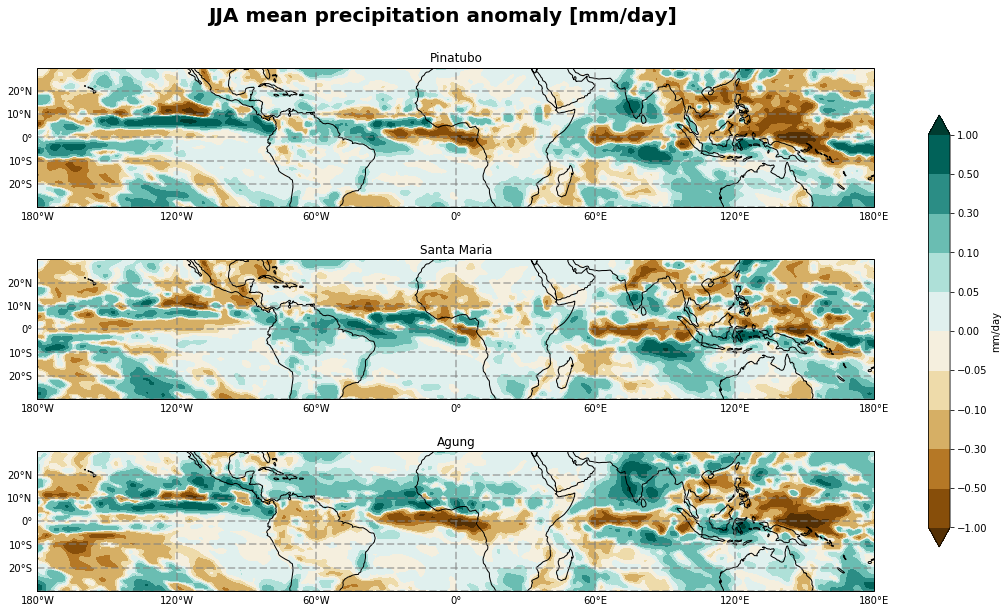

In [16]:
da = [daa_pinatubo_p_jja, daa_stmaria_p_jja, daa_agung_p_jja]
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))


for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='BrBG',levels=[-1,-0.5,-0.3,-0.1,-0.05,0,0.05,0.1,0.3,0.5,1],extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =[-1,-0.5,-0.3,-0.1,-0.05,0,0.05,0.1,0.3,0.5,1], cax=ax,orientation='vertical',label='mm/day')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('JJA mean precipitation anomaly [mm/day]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_tropic_precip_jja.png', bbox_inches='tight')

Text(0.5, 0.95, 'DJF mean precipitation anomaly [mm/day]')

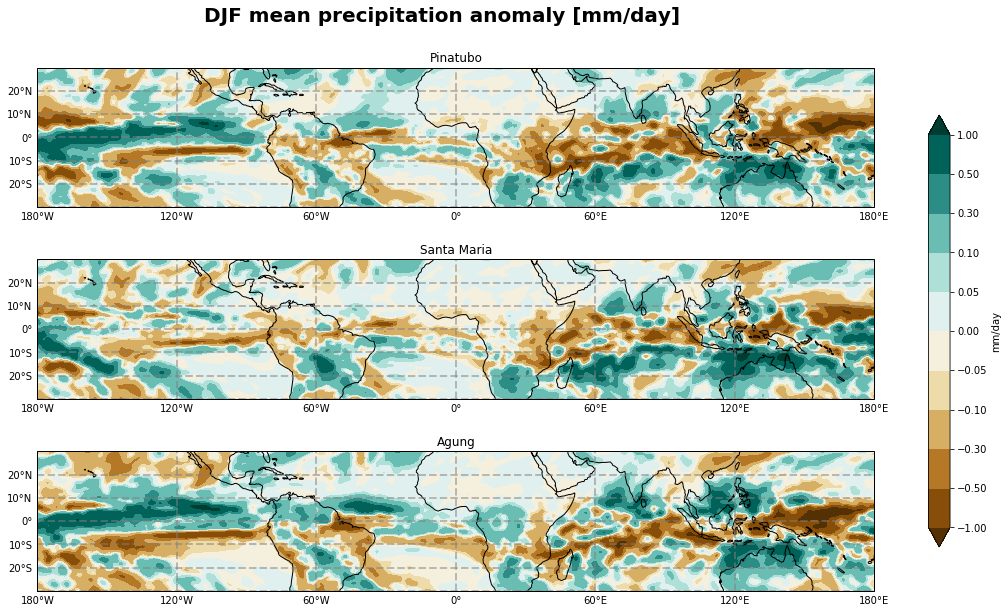

In [17]:
da = [daa_pinatubo_p_djf, daa_stmaria_p_djf, daa_agung_p_djf]
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))


for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='BrBG',levels=[-1,-0.5,-0.3,-0.1,-0.05,0,0.05,0.1,0.3,0.5,1],extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =[-1,-0.5,-0.3,-0.1,-0.05,0,0.05,0.1,0.3,0.5,1], cax=ax,orientation='vertical',label='mm/day')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('DJF mean precipitation anomaly [mm/day]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_tropic_precip_djf.png', bbox_inches='tight')

## 200hPa - TOA

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'JJA 200hPa - TOA energy convergence anomaly [W/m$^2$]')

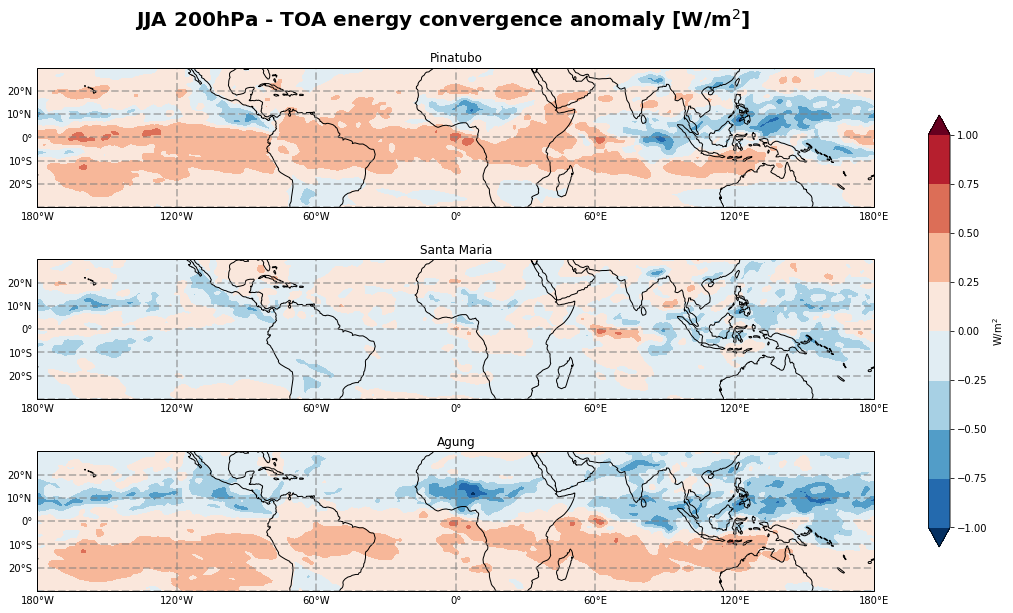

In [31]:
da_pinatubo_conv_jja = pinatubo_netrad_200hPa_jja - pinatubo_toa_jja

da_stmaria_conv_jja = stmaria_netrad_200hPa_jja - stmaria_toa_jja

da_agung_conv_jja = agung_netrad_200hPa_jja - agung_toa_jja



da = [da_pinatubo_conv_jja, da_stmaria_conv_jja, da_agung_conv_jja]
da_s = [0,1,2]
for i in da_s:
    da_s[i] = da[i].isel(lon=(pinatubo_toa.lon<=10)|(pinatubo_toa.lon>=340)).sel(lat=slice(10,20)).where(land_mask>.9,drop=True).mean(['lon','lat'])
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))

levels=[-1,-.75,-.5,-.25,0,.25,.5,.75,1]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='RdBu_r',levels=levels,extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =levels, cax=ax,orientation='vertical',label='W/m$^2$')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('JJA 200hPa - TOA energy convergence anomaly [W/m$^2$]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_strat_conv.png', bbox_inches='tight')

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'DJF 200hPa - TOA energy convergence anomaly [W/m$^2$]')

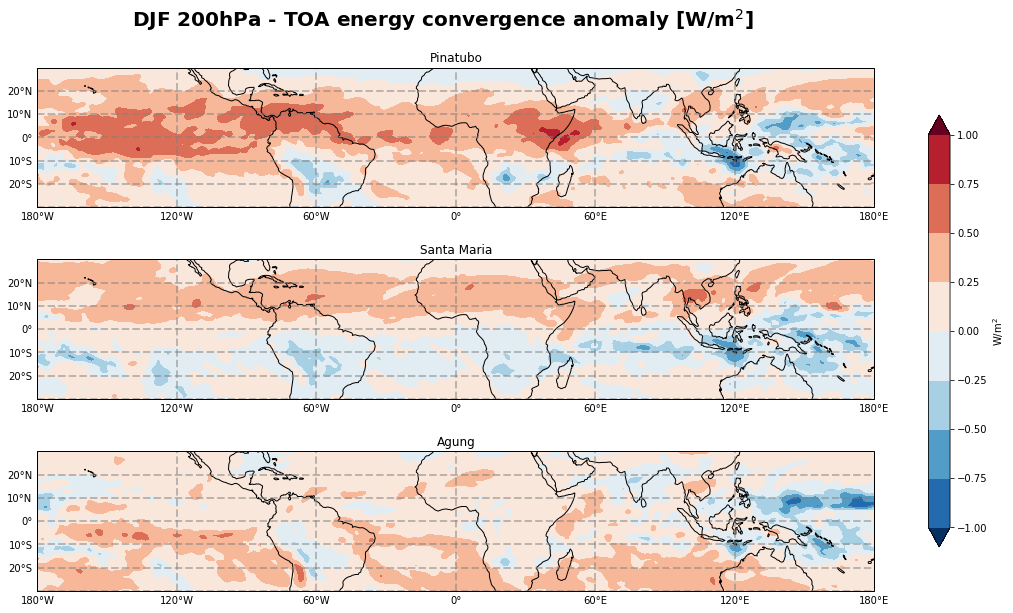

In [32]:
da_pinatubo_conv_djf = pinatubo_netrad_200hPa_djf - pinatubo_toa_djf

da_stmaria_conv_djf = stmaria_netrad_200hPa_djf - stmaria_toa_djf

da_agung_conv_djf = agung_netrad_200hPa_djf - agung_toa_djf



da = [da_pinatubo_conv_djf, da_stmaria_conv_djf, da_agung_conv_djf]
da_s = [0,1,2]
for i in da_s:
    da_s[i] = da[i].isel(lon=(pinatubo_toa.lon<=10)|(pinatubo_toa.lon>=340)).sel(lat=slice(10,20)).where(land_mask>.9,drop=True).mean(['lon','lat'])
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))

levels=[-1,-.75,-.5,-.25,0,.25,.5,.75,1]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='RdBu_r',levels=levels,extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =levels, cax=ax,orientation='vertical',label='W/m$^2$')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('DJF 200hPa - TOA energy convergence anomaly [W/m$^2$]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_strat_conv.png', bbox_inches='tight')

Text(0.5, 0.98, '200hPa to TOA Energy Convergence')

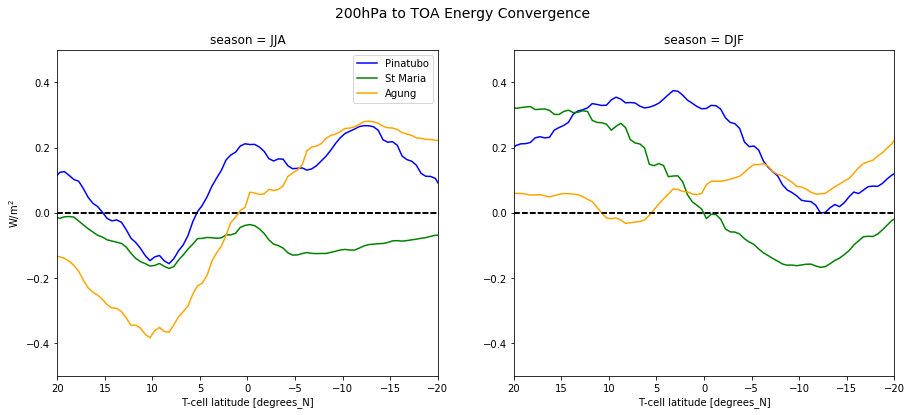

In [34]:
da_pinatubo_conv_jja = pinatubo_netrad_200hPa_jja - pinatubo_toa_jja
da_stmaria_conv_jja = stmaria_netrad_200hPa_jja - stmaria_toa_jja
da_agung_conv_jja = agung_netrad_200hPa_jja - agung_toa_jja
da_pinatubo_conv_djf = pinatubo_netrad_200hPa_djf - pinatubo_toa_djf
da_stmaria_conv_djf = stmaria_netrad_200hPa_djf - stmaria_toa_djf
da_agung_conv_djf = agung_netrad_200hPa_djf - agung_toa_djf


da_jja = [da_pinatubo_conv_jja,da_stmaria_conv_jja,da_agung_conv_jja]
da_djf = [da_pinatubo_conv_djf,da_stmaria_conv_djf,da_agung_conv_djf]
da_za_jja = [0,1,2]
da_za_djf = [0,1,2]
colors = ['b','g','orange']
titles = ['Pinatubo','St Maria', 'Agung']
plt.subplots(1, 2, figsize=(15,6))
jja = plt.subplot(1,2,1)
for i in da_za_jja:
    da_za_jja[i] = da_jja[i].mean(['lon'])
    da_za_jja[i].plot(color=colors[i],label=titles[i])
    jja.set_xlim([20,-20])
    jja.set_ylim(-.5,.5)
    jja.axhline(0,color='k',linestyle='--')
    jja.set_ylabel('W/m$^2$')
    jja.legend()
    
    
djf = plt.subplot(1,2,2)
da_djf = [da_pinatubo_conv_djf,da_stmaria_conv_djf,da_agung_conv_djf]
for i in da_za_djf:
    da_za_djf[i] = da_djf[i].mean(['lon'])
    da_za_djf[i].plot(color=colors[i])
    djf.set_xlim([20,-20])
    djf.set_ylim(-.5,.5)
    djf.axhline(0,color='k',linestyle='--')
    
plt.suptitle('200hPa to TOA Energy Convergence',fontsize=14)


Text(0.5, 0.98, 'Tropical precip zonal mean')

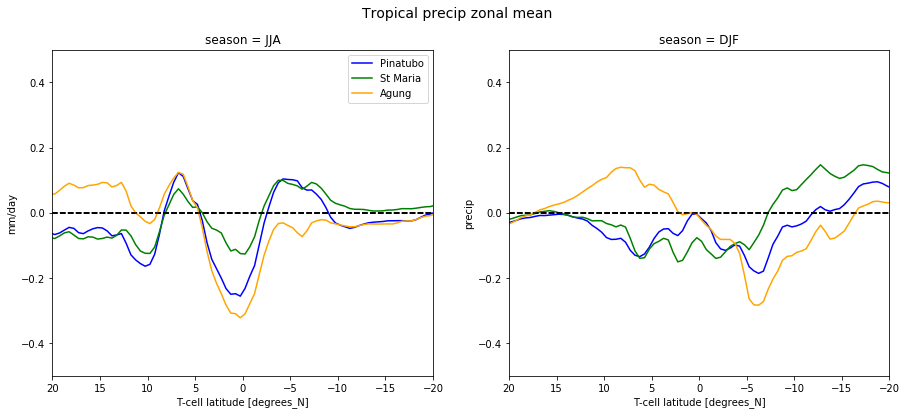

In [37]:
da_jja = [daa_pinatubo_p_jja,daa_stmaria_p_jja,daa_agung_p_jja]
da_djf = [daa_pinatubo_p_djf,daa_stmaria_p_djf,daa_agung_p_djf]
da_za_jja = [0,1,2]
da_za_djf = [0,1,2]
colors = ['b','g','orange']
titles = ['Pinatubo','St Maria', 'Agung']
plt.subplots(1, 2, figsize=(15,6))
jja = plt.subplot(1,2,1)
for i in da_za_jja:
    da_za_jja[i] = da_jja[i].mean(['lon'])
    da_za_jja[i].plot(color=colors[i],label=titles[i])
    jja.set_xlim([20,-20])
    jja.set_ylim(-.5,.5)
    jja.axhline(0,color='k',linestyle='--')
    jja.set_ylabel('mm/day')
    jja.legend()
    
    
djf = plt.subplot(1,2,2)
for i in da_za_djf:
    da_za_djf[i] = da_djf[i].mean(['lon'])
    da_za_djf[i].plot(color=colors[i])
    djf.set_xlim([20,-20])
    djf.set_ylim(-.5,.5)
    djf.axhline(0,color='k',linestyle='--')
    
plt.suptitle('Tropical precip zonal mean',fontsize=14)

## SFC - 200hPa

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'JJA SFC - 200hPa energy convergence anomaly [W/m$^2$]')

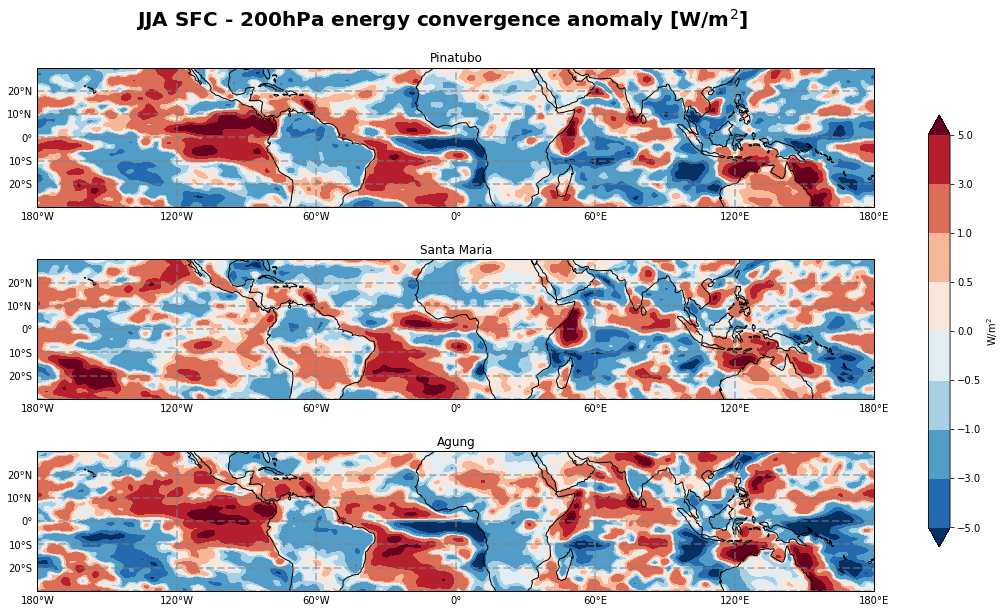

In [30]:
da_pinatubo_conv_jja = pinatubo_sfc_en_jja - pinatubo_netrad_200hPa_jja 

da_stmaria_conv_jja = stmaria_sfc_en_jja - stmaria_netrad_200hPa_jja 

da_agung_conv_jja = agung_sfc_en_jja - agung_netrad_200hPa_jja 



da = [da_pinatubo_conv_jja, da_stmaria_conv_jja, da_agung_conv_jja]
da_s = [0,1,2]
for i in da_s:
    da_s[i] = da[i].isel(lon=(pinatubo_toa.lon<=10)|(pinatubo_toa.lon>=340)).sel(lat=slice(10,20)).where(land_mask>.9,drop=True).mean(['lon','lat'])
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))

levels=[-5,-3,-1,-.5,0,.5,1,3,5]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='RdBu_r',levels=levels,extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =levels, cax=ax,orientation='vertical',label='W/m$^2$')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('JJA SFC - 200hPa energy convergence anomaly [W/m$^2$]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_strat_conv.png', bbox_inches='tight')

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'DJF SFC - 200hPa energy convergence anomaly [W/m$^2$]')

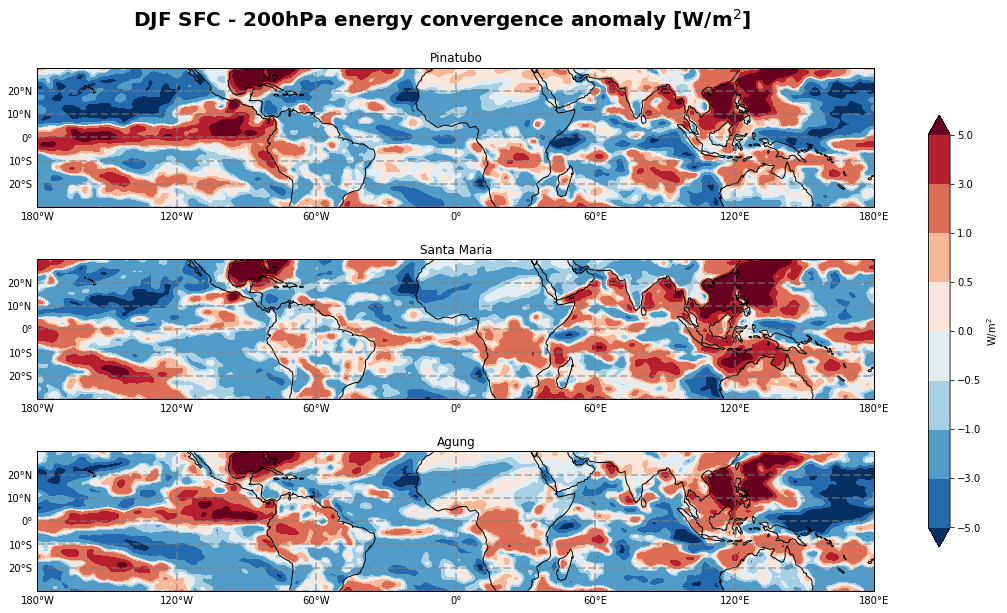

In [33]:
da_pinatubo_conv_djf = pinatubo_sfc_en_djf - pinatubo_netrad_200hPa_djf 

da_stmaria_conv_djf = stmaria_sfc_en_djf - stmaria_netrad_200hPa_djf 

da_agung_conv_djf = agung_sfc_en_djf - agung_netrad_200hPa_djf 



da = [da_pinatubo_conv_djf, da_stmaria_conv_djf, da_agung_conv_djf]
da_s = [0,1,2]
for i in da_s:
    da_s[i] = da[i].isel(lon=(pinatubo_toa.lon<=10)|(pinatubo_toa.lon>=340)).sel(lat=slice(10,20)).where(land_mask>.9,drop=True).mean(['lon','lat'])
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))

levels=[-5,-3,-1,-.5,0,.5,1,3,5]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='RdBu_r',levels=levels,extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =levels, cax=ax,orientation='vertical',label='W/m$^2$')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('DJF SFC - 200hPa energy convergence anomaly [W/m$^2$]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_strat_conv.png', bbox_inches='tight')

Text(0.5, 0.98, 'SFC to 200hPa Energy Convergence')

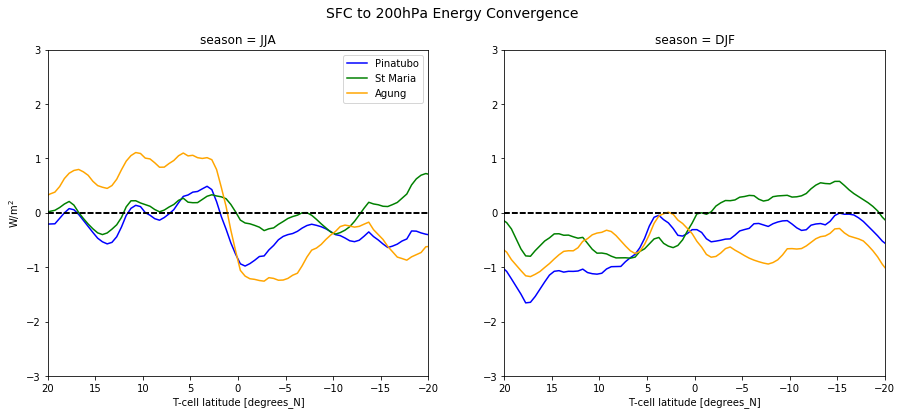

In [40]:
da_pinatubo_conv_jja = pinatubo_sfc_en_jja - pinatubo_netrad_200hPa_jja 
da_stmaria_conv_jja = stmaria_sfc_en_jja - stmaria_netrad_200hPa_jja 
da_agung_conv_jja = agung_sfc_en_jja - agung_netrad_200hPa_jja 
da_pinatubo_conv_djf = pinatubo_sfc_en_djf - pinatubo_netrad_200hPa_djf 
da_stmaria_conv_djf = stmaria_sfc_en_djf - stmaria_netrad_200hPa_djf 
da_agung_conv_djf = agung_sfc_en_djf - agung_netrad_200hPa_djf 


da_jja = [da_pinatubo_conv_jja,da_stmaria_conv_jja,da_agung_conv_jja]
da_djf = [da_pinatubo_conv_djf,da_stmaria_conv_djf,da_agung_conv_djf]
da_za_jja = [0,1,2]
da_za_djf = [0,1,2]
colors = ['b','g','orange']
titles = ['Pinatubo','St Maria', 'Agung']
plt.subplots(1, 2, figsize=(15,6))
jja = plt.subplot(1,2,1)
for i in da_za_jja:
    da_za_jja[i] = da_jja[i].mean(['lon'])
    da_za_jja[i].plot(color=colors[i],label=titles[i])
    jja.set_xlim([20,-20])
    jja.set_ylim(-3,3)
    jja.axhline(0,color='k',linestyle='--')
    jja.set_ylabel('W/m$^2$')
    jja.legend()
    
    
djf = plt.subplot(1,2,2)
for i in da_za_djf:
    da_za_djf[i] = da_djf[i].mean(['lon'])
    da_za_djf[i].plot(color=colors[i])
    djf.set_xlim([20,-20])
    djf.set_ylim(-3,3)
    djf.axhline(0,color='k',linestyle='--')
    
plt.suptitle('SFC to 200hPa Energy Convergence',fontsize=14)


Text(0.5, 0.98, 'Tropical precip zonal mean')

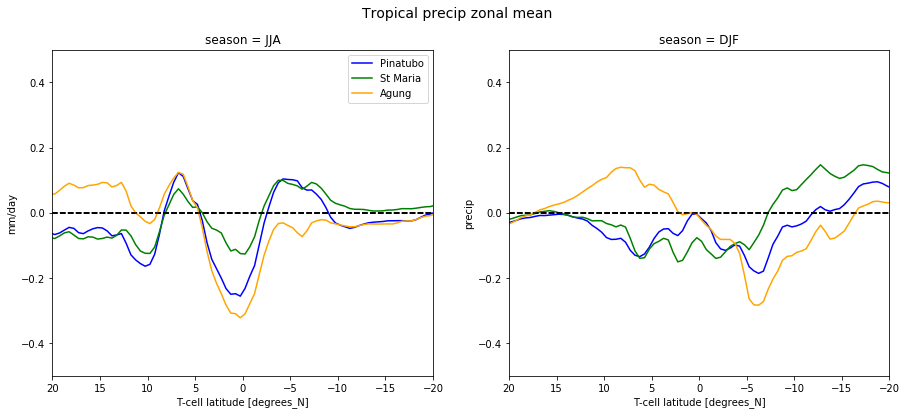

In [41]:
da_jja = [daa_pinatubo_p_jja,daa_stmaria_p_jja,daa_agung_p_jja]
da_djf = [daa_pinatubo_p_djf,daa_stmaria_p_djf,daa_agung_p_djf]
da_za_jja = [0,1,2]
da_za_djf = [0,1,2]
colors = ['b','g','orange']
titles = ['Pinatubo','St Maria', 'Agung']
plt.subplots(1, 2, figsize=(15,6))
jja = plt.subplot(1,2,1)
for i in da_za_jja:
    da_za_jja[i] = da_jja[i].mean(['lon'])
    da_za_jja[i].plot(color=colors[i],label=titles[i])
    jja.set_xlim([20,-20])
    jja.set_ylim(-.5,.5)
    jja.axhline(0,color='k',linestyle='--')
    jja.set_ylabel('mm/day')
    jja.legend()
    
    
djf = plt.subplot(1,2,2)
for i in da_za_djf:
    da_za_djf[i] = da_djf[i].mean(['lon'])
    da_za_djf[i].plot(color=colors[i])
    djf.set_xlim([20,-20])
    djf.set_ylim(-.5,.5)
    djf.axhline(0,color='k',linestyle='--')
    
plt.suptitle('Tropical precip zonal mean',fontsize=14)

# SFC - TOA

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'JJA SFC - TOA energy convergence anomaly [W/m$^2$]')

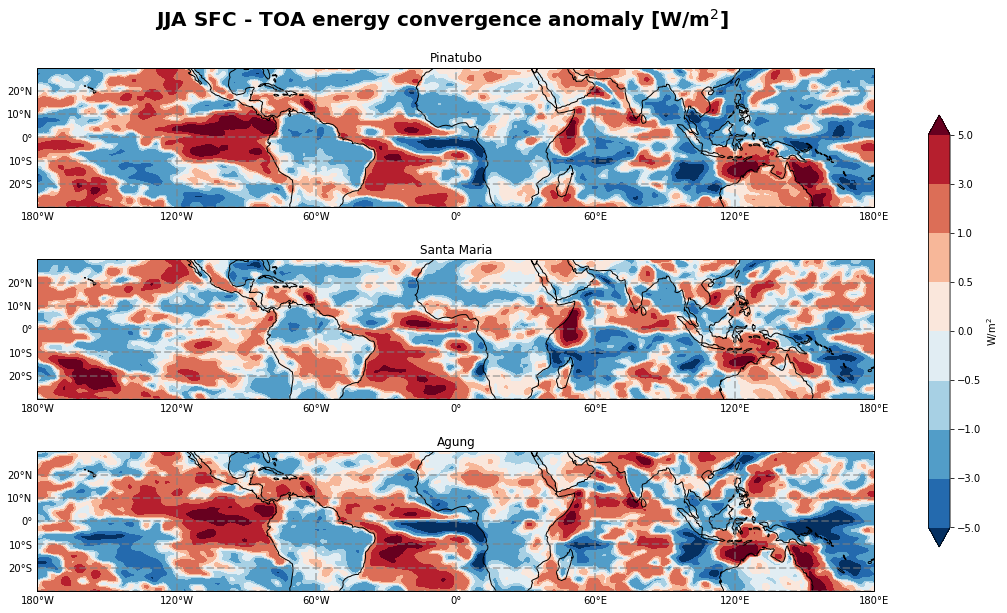

In [42]:
da_pinatubo_conv_jja = pinatubo_sfc_en_jja - pinatubo_toa_jja 

da_stmaria_conv_jja = stmaria_sfc_en_jja - stmaria_toa_jja 

da_agung_conv_jja = agung_sfc_en_jja - agung_toa_jja 



da = [da_pinatubo_conv_jja, da_stmaria_conv_jja, da_agung_conv_jja]
da_s = [0,1,2]
for i in da_s:
    da_s[i] = da[i].isel(lon=(pinatubo_toa.lon<=10)|(pinatubo_toa.lon>=340)).sel(lat=slice(10,20)).where(land_mask>.9,drop=True).mean(['lon','lat'])
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))

levels=[-5,-3,-1,-.5,0,.5,1,3,5]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='RdBu_r',levels=levels,extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =levels, cax=ax,orientation='vertical',label='W/m$^2$')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('JJA SFC - TOA energy convergence anomaly [W/m$^2$]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_strat_conv.png', bbox_inches='tight')

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2710: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


Text(0.5, 0.95, 'DJF SFC - TOA energy convergence anomaly [W/m$^2$]')

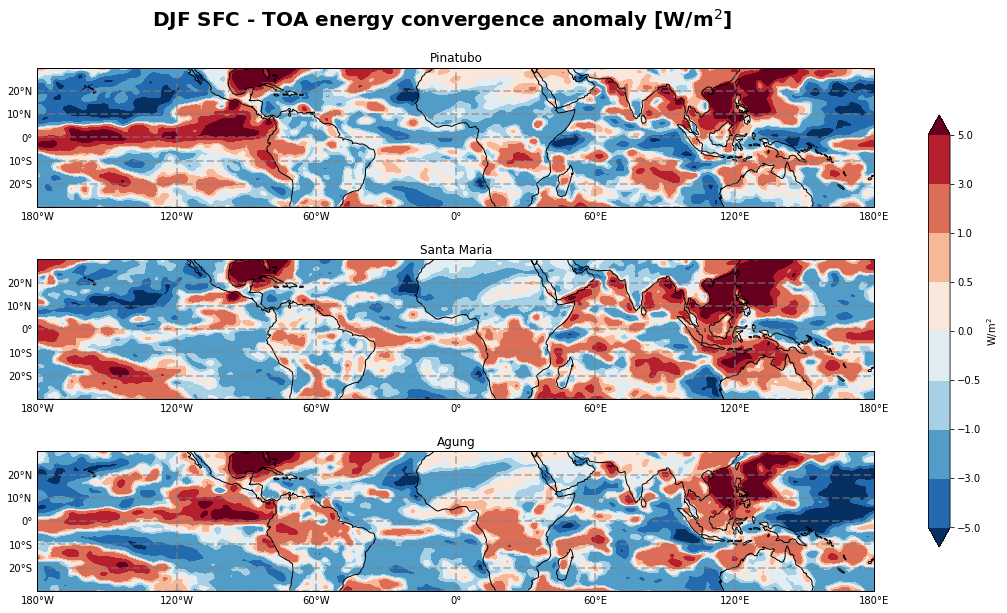

In [43]:
da_pinatubo_conv_djf = pinatubo_sfc_en_djf - pinatubo_toa_djf 

da_stmaria_conv_djf = stmaria_sfc_en_djf - stmaria_toa_djf 

da_agung_conv_djf = agung_sfc_en_djf - agung_toa_djf 



da = [da_pinatubo_conv_djf, da_stmaria_conv_djf, da_agung_conv_djf]
da_s = [0,1,2]
for i in da_s:
    da_s[i] = da[i].isel(lon=(pinatubo_toa.lon<=10)|(pinatubo_toa.lon>=340)).sel(lat=slice(10,20)).where(land_mask>.9,drop=True).mean(['lon','lat'])
titles = ['Pinatubo', 'Santa Maria', 'Agung' ]

fig, axes = plt.subplots(3, 1, figsize=(15,10))

levels=[-5,-3,-1,-.5,0,.5,1,3,5]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(3,1,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180, -30, 30], ccrs.PlateCarree())
    im = shift_longitude(da[ii]).rolling(lon=5, min_periods=1, center=True).mean().rolling(lat=5, min_periods=1, center=True).mean().plot.contourf(robust=True, cmap='RdBu_r',levels=levels,extend='both', add_labels=False, add_colorbar=False)
    g3=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    g3.xlabels_top=False
    g3.ylabels_right=False
    g3.xformatter=LONGITUDE_FORMATTER
    g3.yformatter=LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    ax.set_title(titles[ii])

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,ticks =levels, cax=ax,orientation='vertical',label='W/m$^2$')
#plt.tight_layout()#(rect=(0,0,1,1))

plt.suptitle('DJF SFC - TOA energy convergence anomaly [W/m$^2$]',fontsize=20, fontweight='demi',y=.95)
#smoothed over 5x5 degrees
#plt.savefig('glob_strat_conv.png', bbox_inches='tight')

Text(0.5, 0.98, 'SFC to TOA Energy Convergence')

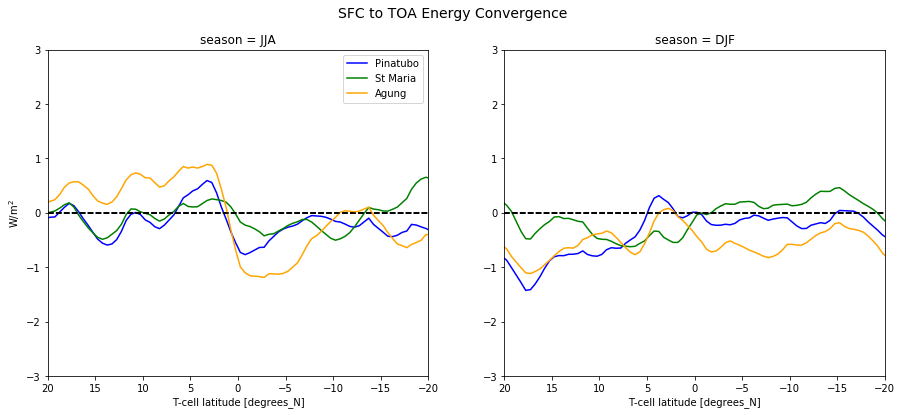

In [44]:
da_pinatubo_conv_jja = pinatubo_sfc_en_jja - pinatubo_toa_jja 
da_stmaria_conv_jja = stmaria_sfc_en_jja - stmaria_toa_jja 
da_agung_conv_jja = agung_sfc_en_jja - agung_toa_jja 
da_pinatubo_conv_djf = pinatubo_sfc_en_djf - pinatubo_toa_djf 
da_stmaria_conv_djf = stmaria_sfc_en_djf - stmaria_toa_djf 
da_agung_conv_djf = agung_sfc_en_djf - agung_toa_djf 


da_jja = [da_pinatubo_conv_jja,da_stmaria_conv_jja,da_agung_conv_jja]
da_djf = [da_pinatubo_conv_djf,da_stmaria_conv_djf,da_agung_conv_djf]
da_za_jja = [0,1,2]
da_za_djf = [0,1,2]
colors = ['b','g','orange']
titles = ['Pinatubo','St Maria', 'Agung']
plt.subplots(1, 2, figsize=(15,6))
jja = plt.subplot(1,2,1)
for i in da_za_jja:
    da_za_jja[i] = da_jja[i].mean(['lon'])
    da_za_jja[i].plot(color=colors[i],label=titles[i])
    jja.set_xlim([20,-20])
    jja.set_ylim(-3,3)
    jja.axhline(0,color='k',linestyle='--')
    jja.set_ylabel('W/m$^2$')
    jja.legend()
    
    
djf = plt.subplot(1,2,2)
for i in da_za_djf:
    da_za_djf[i] = da_djf[i].mean(['lon'])
    da_za_djf[i].plot(color=colors[i])
    djf.set_xlim([20,-20])
    djf.set_ylim(-3,3)
    djf.axhline(0,color='k',linestyle='--')
    
plt.suptitle('SFC to TOA Energy Convergence',fontsize=14)
